In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [84]:
training_set = pd.read_csv('datasets/scaled_v1_50.csv')
training_set

x       y       Phi
0      100.0   100.0  0.101687
1      350.0   350.0  0.085555
2      550.0   550.0  0.086528
3      750.0   750.0  0.122924
4      950.0   950.0  0.101047
...      ...     ...       ...
2495  9150.0  9150.0  0.143925
2496  9350.0  9350.0  0.094077
2497  9550.0  9550.0  0.140941
2498  9750.0  9750.0  0.147692
2499  9900.0  9900.0  0.081021

[2500 rows x 3 columns]

In [69]:
training_set = training_set.iloc[:,2:3].values
training_set

array([[0.10168731],
       [0.08555495],
       [0.08652839],
       ...,
       [0.14094058],
       [0.14769171],
       [0.08102139]])

In [70]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [71]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [74]:
num_epochs = 700 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 9 #6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.45739
Epoch: 100, loss: 0.08634
Epoch: 200, loss: 0.08634
Epoch: 300, loss: 0.08633
Epoch: 400, loss: 0.08632
Epoch: 500, loss: 0.08631
Epoch: 600, loss: 0.08630


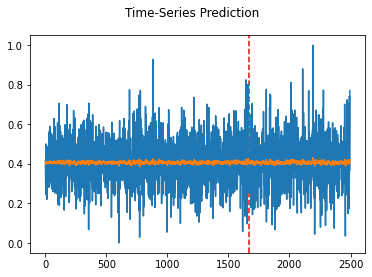

In [82]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [81]:
data_predict - dataY_plot

array([[-0.00841135],
       [ 0.05878636],
       [ 0.0732317 ],
       ...,
       [ 0.04901108],
       [-0.30911952],
       [-0.3500207 ]], dtype=float32)

In [75]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

NameError: name 'loss_values' is not defined

<Figure size 720x432 with 0 Axes>

In [52]:
data_predict

array([[0.1001242 ],
       [0.09994511],
       [0.09978104],
       ...,
       [0.10057902],
       [0.10021213],
       [0.1015515 ]], dtype=float32)

In [87]:
data = pd.read_csv('datasets/scaled_v1_50.csv')

In [88]:
X = np.zeros([len(data.index),1]) #Features: Time, Difference, Rate
y = np.zeros([len(data.index),1])

In [89]:
X[:,0] = data.x.values
#X[:,1] = data.y.values
y = data.Phi.values

In [93]:
n_features=1
train= len(data.index)-20
test = len(data.index) - train
X_train = X[:train,:]
X_test= X[train:,:]
y_train = y[:train] 
y_test = y[train:]

y_train = y_train.reshape((y_train.shape[0]),1)
y_test = y_test.reshape((y_test.shape[0]),1)

In [94]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [95]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [96]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([2480, 1, 1]) torch.Size([2480, 1])
Testing Shape torch.Size([20, 1, 1]) torch.Size([20, 1])


In [97]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, p = 0.01):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 1024) #fully connected 1
        self.fc_2 =  nn.Linear(1024,1024) #fully connected 1
        self.fc_3 =  nn.Linear(64,32) #fully connected 1
        self.fc = nn.Linear(1024, num_classes) #fully connected last layer
        self.p = p
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        #out = nn.functional.dropout(out, p=self.p, training=True)
        out = self.fc_1(out) #first Dense
        out = nn.functional.dropout(out, p=self.p, training=True)
        out = self.relu(out) #relu
        
        out = self.fc_2(out) #second Dense
        out = nn.functional.dropout(out, p=self.p, training=True)
        out = self.relu(out) #relu
                
        out = self.fc(out) #Final Output
        return out
        


In [107]:
num_epochs = 700 #1000 epochs
learning_rate = 0.001#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 7#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

In [108]:
lstm1 = LSTM1(num_classes,
              input_size,
              hidden_size,
              num_layers,
              trainX.shape[1],
              p=dropout)

In [109]:
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [112]:
loss_values=[]
loss_test_values=[]
# for epoch in range(num_epochs):
    
    #scheduler.step(loss_test)
    # Train the model
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    loss.backward() #calculates the loss of the loss function
    loss_values.append(loss.item())

    
    test_output = lstm1.forward(X_test_tensors_final) #forward pass
    loss_test = criterion(test_output, y_test_tensors)
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01182


KeyboardInterrupt: 